# Продуктовые А/B тесты

## Часть 1. Сбор данных по продуктовым А/B тестам

`А/B тестирование (split testing - раздельное тестирование)` - маркетинговый метод, использующийся для оценки и управления эффективностью веб-страницы. А/B тестирование позволяет оценить показатели работы двух вариантов веб-страницы и сравнить их между собой. Практический смысл использования метода заключается в поиске и внедрении компонентов страницы, увеличивающих ее результативность. 

Сплит тестирование начинается с оценки метрик существующей веб-страницы и поиска способов ее улучшения.
С помощью инструментов для проведения теста эксперт в случайном порядке разделяет трафик между страницами А и B на две приблизительно равные части. При этом важно обеспечить объективность тестирования и в равной степени учесть все источники трафика: cpc, meta, organic, direct и др. Собрав достаточно информации, аналитик оценивает результаты тестирования.

`Цель дипломного проекта` - автоматизировать сбор и анализ данных по A/B тестированиям, проходящих на сайте  [Utair.ru](https://www.utair.ru/ "Я ссылка")

Целью 1 части дипломного проекта определяются следующие `задачи`:
* используя Power BI автоматизировать расчет размера выборки, необходимого для проведения теста;
* используя Python собрать результаты теста:
  1. из базы данных ClickHouse: количество пользователей по шагам, количество успешных заказов;
  2. из базы SalesUT (SQL Server): финансовый результат по группам А и B;
* в базе данных PostgreSQL создать справочник тестов и таблицы результатов;
* подключиться через Power BI к базе данных PostgreSQL и настроить отчет, содержащий в себе следующие показатели:
  1. воронку тестовой и контрольной групп;
  2. итоговое значение и динамику конверсии в успешную оплату;
  3. динамику заказов по этапам;
  4. финансовый результат по группам;
  6. статистическую значимость различий в тестируемой и конрольной группах.
* сделать вывод об эффективности проводимого теста.

`Перечень инструментов`, используемых в работе: 
* Power BI (комплексное программное обеспечение бизнес анализа) для визуализации данных. В 1 части дипломного проекта Python не используется для отрисовки графиков по причине сложности работы менеджеров с отчетами в формате jyputer notebook (и pdf, если конвертировать);
* Python 3 для сбора и анализа данных;
* Jupyter как среда для написания скриптов;
* SQL для работы с базами данных;
* базы данных ClickHouse, SQL Server, PostgeSQL как источники данных.


<p align="center">

  <img width="800" height="450" src="https://leadstartup.ru/db-assets/photos/1110/c-level-api-cdbc61ae3467c3fa1fbc4842c9aaa41f.jpg">

</p>

### 1. Определение размера выборки

Выборку, необходимую для проведения теста можно определить по формуле:

$$n = {2*(Z_a+Z_b)^2*p*(1-p)}\over{\Delta^2}$$

где:
* Za - значение Z при p-value 5% (1,96);
* Zb - значение Z при мощности 80% (0,84);
* p - текущая конверсия (до проведения теста), %;
* Δ - ожидаемый эффект, %.

Чаще всего используют p-value 5% и мощность 80%, поэтому коэффициенты зафиксированы.

Расчет проведен в Power BI. Т.к. я не могу дать доступ к рабочей области Power BI, экспортирую отчет в pdf (файл называется "Часть1. Продуктовые тесты. Отчет в Power BI"). На защите будет показан отчет в рабочей области. 

### 2. Импортирование библиотек

In [1]:
# импорт библиотек для работы с dataset
from datetime import datetime, date
import numpy as np
import pandas as pd

# импорт библиотек для работы с базами данных
from pymongo import MongoClient
from clickhouse_driver.client import Client
import sqlalchemy
import pyodbc
import pymssql
import postgresql
import psycopg2 as ps

from infi.clickhouse_orm import Database
# опция для вывода колонок в dataset
pd.set_option('display.max_columns', 50) 

### 3. Ввод параметров для справочника А/В тестов

Для каждого А/B теста в справочнике `dic_product_ab_tests` в базе данных PostgeSQL создается строка, содержащая следующую информацию:
* TASK - номер задачи в система Jira;
* TEST_NAME - группа теста;
* HYPOTHESIS - гипотеза, которая подвергается проверке;
* DATE_START - дата начала теста;
* DATE_END - дата конца теста;
* PAGE_URL_ - метка теста;
* PAGE_REF - метка теста;
* GROUP_CONTROL- метка контрольной группы;
* GROUP_TEST - метка тестовой группы;
* SUCCESS - этап, который соответствует успешной оплате заказа. 

In [2]:
# ввод данных в справочник продуктовых тестов
DICTIONARY = 'dic_product_ab_tests'
TASK = 'DANLT-36'
TEST_NAME = 'Тарифная_выдача'
HYPOTHESIS = 'Если предвыбирать пользователю тариф premium, то вырастет конверсия в покупку тарифа'
DATE_START = '2021-03-01 00:00:00'
DATE_END = '2021-03-09 00:00:00'
PAGE_URL_ = '%utair.ru/booking/%'
PAGE_REF = 'https://www.utair.ru/'
GROUP_CONTROL = 'flow=3'
GROUP_TEST = 'flow=4'
SUCCESS = '4_Успешная оплата'

# определение наименований таблиц результатов
RESULT_TABLE_CLICK = 'report_click_product_ab_tests'
RESULT_TABLE_SALE = 'report_sale_product_ab_tests'

### 4. Функции для подключения к базам данных и работы с dataset

In [3]:
def create_connection_postgre(db_name, db_users, db_password, db_host, db_port):
    
    """функция используется для подключения к базе postgreSQL"""
    
    connection = None
    try:
        connection = ps.connect(
        database=db_name,
        user=db_users,
        password=db_password,
        host=db_host,
        port=db_port,
        )
        print("Подключение к postgre установлено")
    except ps.OperationalError as e:
        print(f"Возникла ошибка подключения:'{e}'")
    return connection

 
def execute_query(connection, query):
    
    """функция используется для выполнения запроса к базе postgreSQL"""
    
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Запрос к postgre выполнен")
    except ps.OperationalError as e:
        print(f"В запросе ошибка:'{e}'")
        
def connection_clickhouse(db_url, db_user, db_password):
    
    """функция используется для подключения к базе clickhouse"""
    
    connection = Database(
        'stats',
        db_url=db_url,
        username=db_user,
        password=db_password,
        readonly=True,
        verify_ssl_cert=False,
        timeout=200,
        )
    return connection

def query_clickhouse(connection, query):
    
    """функция используется для выполнения запроса к базе clickhouse"""
    
    result = connection.select(query)
    print("Запрос к clickhouse выполнен")
    return result

def connection_sale():
    
    """функция используется для подключения к базе salesut"""
    
    connection = pymssql.connect(
        server='ХХХХХХХХХХХХ', 
        user='ХХХХХХХХХХХХ', 
        password='ХХХХХХХХХХХХ', 
        database='ХХХХХХХХХХХХ'
    )
    print("Подключение к SalesUT установлено")
    return connection

def query_sale(connection, query):
    
    """функция используется для выполнения запроса к базе salesut"""
    
    cur = connection.cursor()
    cur.execute(query)
    result = cur.fetchall()
    print("Запрос выполнен")
    return result

def description_column(x):
    
    """Функция используется для описания 
     столбца текстового типа """
    
    print('Количество уникальных значений в столбце:',x.nunique())
    print('Перечень уникальных значений:', x.unique())
    print('Длина столбца:',len(x))
    print('Количество значений "NaN":', x.isna().sum())
    print("Количество значений, встретившихся в столбце более 10 раз:", (x.value_counts()>10).sum())

def description_column_count(x):
    
    """Функция используется для описания 
     столбца числового типа """
    
    print('Длина столбца:',len(x))
    print('Количество значений "NaN":', x.isna().sum())
    print('Минимальное значение:', x.min())
    print('Максимальное значение:',x.max())  

### 5. Создание справочника продуктовых А/В тестов

При создании таблицы важно устранить возможность дублирования данных путем создания индексов и ограничений.

In [4]:
# создание справочника продуктовых тестов
create_dictionary = f"""
    create table if not exists {DICTIONARY}
    (task         varchar   NOT NULL,  /*Номер задачи в Jira*/
    test_name     varchar   NOT NULL,  /*Наименование теста*/
    hypothesis    varchar   NOT NULL,  /*Описание гипотезы*/
    date_start    timestamp NOT NULL,  /*Дата начала теста*/
    date_end      timestamp NOT NULL,  /*Дата завершения теста*/
    page_ref      varchar   NULL,      /*Метка теста*/
    page_url      varchar   NULL,      /*Метка теста*/
    group_control varchar   NOT NULL,  /*Обозначение контрольной группы*/
    group_test    varchar   NOT NULL); /*Обозначение тестовой группы*/
    
"""
execute_query(create_connection_postgre(ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ),create_dictionary)

# создание индексов и ограничений, которые помогают избежать дубликатов
create_index_dic = f"""create index if not exists "id" on "{DICTIONARY}" (task)"""
execute_query(create_connection_postgre(ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ), create_index_dic)


create_constraint_dic = f"""alter table "{DICTIONARY}" add constraint "jira_task_constraint" unique (task)"""
execute_query(create_connection_postgre(ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ), create_constraint_dic)

### 6. Наполнение справочника продуктовых А/В тестов

In [5]:
# наполним справочник тестов параметрами, указанными в пункте 2
insert_data_dic = f"""
insert into {DICTIONARY} (task, test_name, hypothesis, date_start, date_end, page_ref, page_url, group_control, group_test)
values ('{TASK}', '{TEST_NAME}', '{HYPOTHESIS}', '{DATE_START}', '{DATE_END}', '{PAGE_REF}', '{PAGE_URL_}', 
'{GROUP_CONTROL}', '{GROUP_TEST}')
on conflict on constraint jira_task_constraint
do update
set task = EXCLUDED.task,   
    test_name = EXCLUDED.test_name,
    hypothesis = EXCLUDED.hypothesis,
    date_start = EXCLUDED.date_start,
    date_end = EXCLUDED.date_end, 
    page_ref = EXCLUDED.page_ref,   
    page_url = EXCLUDED.page_url,   
    group_control = EXCLUDED.group_control,
    group_test = EXCLUDED.group_test
"""
execute_query(create_connection_postgre(ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ), insert_data_dic)

В результате в PostgreSQL сформирован справочник А/B тестов, который впоследствии будет наполняться новыми данными.

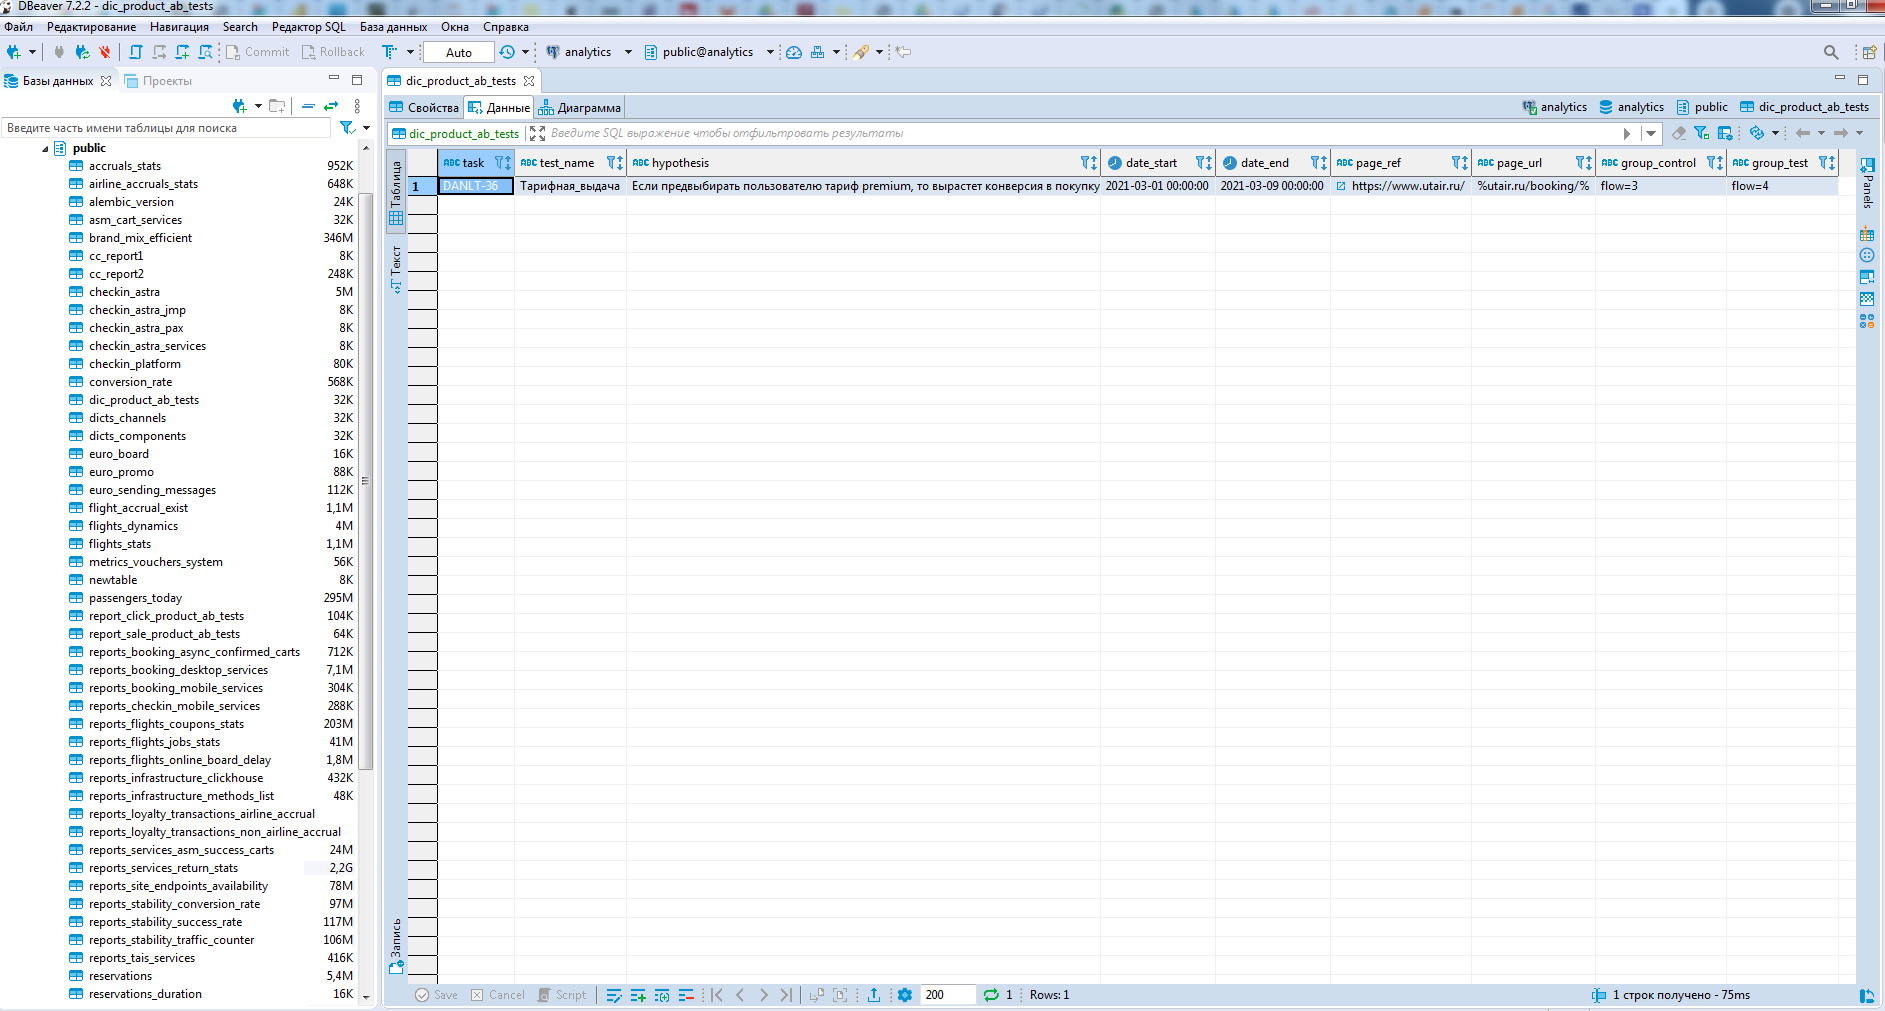

### 7. Создание таблицы результатов  по кликам

В таблице `report_click_product_ab_tests` соберем информацию по этапам, который прошел пользователь тестовой и контрольной групп за весь период теста.

In [6]:
create_result_table_click = f"""create table if not exists {RESULT_TABLE_CLICK}
(task           varchar     NOT NULL,  /*Номер задачи в jira, id для связи со справочником*/
test_name       varchar     NOT NULL,  /*Наименование теста*/
groups_test     varchar     NOT NULL,  /*Содержит 2 значения: control, test. Метки смотреть в справочнике*/
date_test       timestamp   NOT NULL,  /*Дата эксперимента*/
level_name      varchar     NOT NULL,  /*Наименование события и его номер*/
users           integer     NOT NULL); /*Количество пользователей*/

"""
execute_query(create_connection_postgre(ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ), create_result_table_click)

# создание индексов и ограничений, которые помогают избежать дубликатов
create_index_result_click = f""" create index if not exists "id" on "{RESULT_TABLE_CLICK}" (task, test_name, groups_test, date_test, level_name) """
execute_query(create_connection_postgre(ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ), create_index_result_click)

create_constraint_result_click = f"""alter table "{RESULT_TABLE_CLICK}" add constraint "task_constraint" unique (task, test_name, groups_test, date_test, level_name)"""
execute_query(create_connection_postgre(ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ), create_constraint_result_click) 


### 8. Наполнение таблицы результатов по кликам

In [7]:
# соберем данные из базы ClickHouse
click_query = f"""
select date_sale, version, levels[num] as level_name, users_visited[num] as users_visited
from
  (select date_sale, version, 
  sum(count_cart) as total, 
  groupArray(level_name) levels,
  groupArray(count_cart) users_by_levels,
  groupArrayMovingSum(count_cart) users_by_levels_sum,
  arrayMap(i -> (total - users_by_levels_sum[i-1]), arrayEnumerate(users_by_levels_sum)) as users_visited,
  (users_visited[length(arrayEnumerate(users_visited))] / total) as total_conversion,
  arrayMap(i -> (users_visited[i] / users_visited[i-1]), arrayEnumerate(users_visited)) as step_conversion         
   from
     (select date_sale, version, level_name, count(cart) as count_cart
      from
        (select cart, version, date_sale, level_name
         from
           (select
           if(data_extra.value[indexOf(data_extra.key, 'eventParams_cart_id')] = '', data_extra.value[indexOf(data_extra.key, 'cart_id')], data_extra.value[indexOf(data_extra.key, 'eventParams_cart_id')]) as cart,
           if(max(extract(page_url, 'flow=[0-9]')) <> '', max(extract(page_url, 'flow=[0-9]')), 'out') as version,
            max(toDate(dateTime)) as date_sale,
            windowFunnel(6048000000000000, 'strict')(dateTime,
                                                name = 'fares_shown'
                                                and page_ref = '{PAGE_REF}' as fares,
                                                name = 'personal_data_page_loaded' as personal_data,
                                                name = 'services_page_loaded' as services,
                                                name = 'payment_successful' as success) as level,
            ['1_Вывод тарифной выдачи', '2_Переход на ввод персональных данных','3_Загружена страница выбора услуг','4_Успешная оплата'][level] as level_name
            from stats.events_d
            where page_url like '{PAGE_URL_}' and dateTime between '{DATE_START}' and '{DATE_END}'
            group by cart)
        where level_name <> '' and version <> 'out')
      group by date_sale, version, level_name
      order by date_sale, version, level_name)
  group by date_sale, version) ARRAY
  join arrayEnumerate(levels) as num
  where version = '{GROUP_CONTROL}' or version = '{GROUP_TEST}'
  order by date_sale, version asc
"""
# cформируем dataframe
def transform_data_click(connection, query):
    table = pd.DataFrame()
    task = []
    test_name = []
    version = []
    date_sale = []
    level_name = []
    users = []
    for row in query_clickhouse(connection, query):
        version.append(row.version)
        date_sale.append(row.date_sale.strftime('%Y-%m-%d %H:%M:%S'))
        level_name.append(row.level_name)
        users.append(row.users_visited)
        task.append(TASK)
        test_name.append(TEST_NAME)
    table['task'] = np.array(task)
    table['test_name'] = np.array(test_name)
    table['version'] = np.array(version)
    table['groups'] = np.where(table['version'] == GROUP_CONTROL, 'control', 'test')
    table['date'] = np.array(date_sale)
    table['level'] = np.array(level_name)
    table['users'] = np.array(users)
    table.drop(['version'], inplace=True, axis=1)
    result = pd.pivot_table(table, values='users', index=['task', 'test_name', 'groups', 'date', 'level'], aggfunc=np.sum)
    result = result.reset_index()
    return pd.DataFrame(result)

# построчно зальем данные в таблицу report_click_product_ab_tests
for i in transform_data_click(connection_clickhouse(ХХХХХХ, ХХХХХХ, ХХХХХХ), click_query).to_numpy():
    PARAM = tuple(i)
    sql = """
    insert into public.report_click_product_ab_tests
    (task, test_name, groups_test, date_test, level_name, users)
    values {0}
    on conflict on constraint task_constraint
    do update
    set task=EXCLUDED.task,
        test_name=EXCLUDED.test_name,
        groups_test=EXCLUDED.groups_test,
        date_test=EXCLUDED.date_test,
		level_name=EXCLUDED.level_name,
		users=EXCLUDED.users;
    """.format(PARAM)
    execute_query(create_connection_postgre(ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ),sql)
    print(sql)

Запрос к clickhouse выполнен


В результате была сформирована таблица-результат по шагам, который прошел пользователь на сайте от захода на него до успешной оплаты.

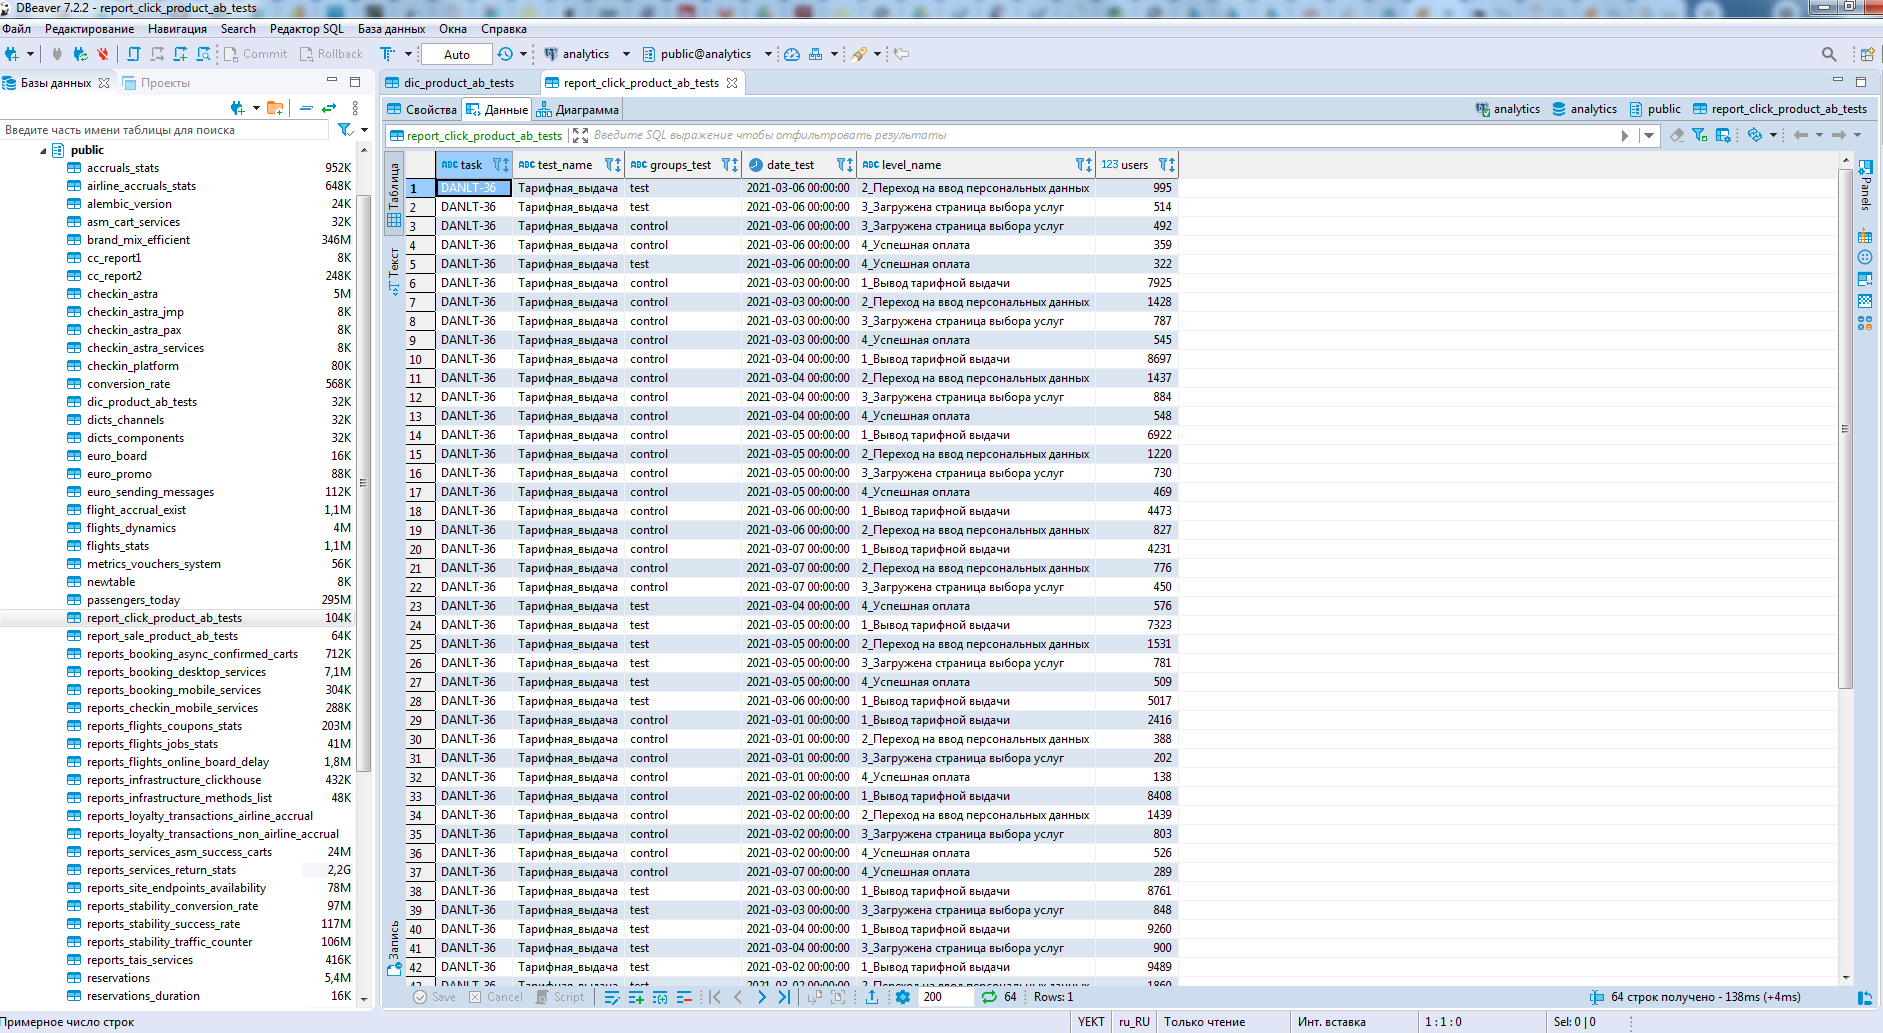

### 9. Создание таблицы финансовых результатов

В таблице `report_sale_product_ab_tests` будут собраны финансовые и производственные данные по тестам в разрезе бренда и канала продажи:
* количество пассажиров и броней (заказов);
* выручка от продажи пассажирских билетов;
* наценка от базовой цены (влияние бренда, база = цена минимум);
* количество багажа и прочих дополнительных услуг;
* выручка от багажа;
* выручка от прочих дополнительных услуг;
* ставки доходные и расходные.

In [8]:
# cоздание таблицы для сбора финансовых результатов из SalesUT
create_result_table_sales = f""" create table if not exists {RESULT_TABLE_SALE}
(task           varchar     NOT NULL, /*Номер задачи в jira, id для связи со справочником*/
test_name       varchar     NOT NULL, /*Наименование теста*/
groups_test     varchar     NOT NULL, /*Содержит 2 значения: control, test. Метки для каждой из групп смотреть в справочнике*/
date_test       timestamp   NOT NULL, /*Дата эксперимента*/
brand           varchar     NOT NULL, /*Бренды*/
canal           varchar     NOT NULL, /*Канал*/
count_segments  integer     NOT NULL, /*Количество сегментов*/
count_pnr       integer     NOT NULL, /*Количество броней*/
revenue_rub     float       NOT NULL, /*Базовая выручка в рублях*/
extra_rub       float       NOT NULL, /*Наценка в рублях*/
baggage_rub     float       NOT NULL, /*Выручка от багажа в рублях*/
count_baggage   float       NOT NULL, /*Количество багажа*/
services_rub    float       NOT NULL, /*Выручка от прочих услуг в рублях*/
count_services  float       NOT NULL, /*Количество услуг*/
expenses_rub    float       NOT NULL, /*Расходы на канал в рублях*/
rate_rub        float       NOT NULL); /*Такса на канал в рублях*/ 
"""
execute_query(create_connection_postgre(ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ), create_result_table_sales)


create_index_result_sale = f""" create index if not exists "id" on "{RESULT_TABLE_SALE}" (task, test_name, groups_test, date_test, brand, canal) """
execute_query(create_connection_postgre(ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ), create_index_result_sale)

create_constraint_result_sale = f"""alter table "{RESULT_TABLE_SALE}" add constraint "task_constraint_sale" unique (task, test_name, groups_test, date_test, brand, canal)"""
execute_query(create_connection_postgre(ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ, ХХХХХХ), create_constraint_result_sale)


Подключение к postgre установлено
Запрос к postgre выполнен
Подключение к postgre установлено
Запрос к postgre выполнен
Подключение к postgre установлено
Запрос к postgre выполнен


### 10. Наполнение таблицы финансовых результатов

In [9]:
# сбор данных по успешным броням из ClickHouse
click_query_pnr = f"""
select distinct rloc, version
      from
        (select cart, version, date_sale, level_name, rloc
         from
           (select
           if(data_extra.value[indexOf(data_extra.key, 'eventParams_cart_id')] = '', data_extra.value[indexOf(data_extra.key, 'cart_id')], data_extra.value[indexOf(data_extra.key, 'eventParams_cart_id')]) as cart,
           if(max(extract(page_url, 'flow=[0-9]')) <> '', max(extract(page_url, 'flow=[0-9]')), 'out') as version,
            max(data_extra.value[indexOf(data_extra.key, 'pnr')]) as rloc,
            max(toDate(dateTime)) as date_sale,
            windowFunnel(6048000000000000, 'strict')(dateTime,
                                                name = 'fares_shown'
                                                and page_ref = '{PAGE_REF}' as fares,
                                                    name = 'personal_data_page_loaded' as personal_data,
                                                    name = 'services_page_loaded' as services,
                                                    name = 'payment_successful' as success) as level,
            ['1_Вывод тарифной выдачи', '2_Переход на ввод персональных данных','3_Загружена страница выбора услуг','4_Успешная оплата'][level] as level_name

            from stats.events_d
            where page_url like '{PAGE_URL_}' and dateTime between '{DATE_START}' and '{DATE_END}'
            group by cart)
        where level_name <> '' and version <> 'out')
        where level_name = '{SUCCESS}'
"""

# в списках будут лежать успешные брони и версии
list_success_pnr=[]
version=[]

def success_pnr(connection, query):
    for row in query_clickhouse(connection, query):
        i=row.rloc
        j=row.version
        list_success_pnr.append(i)
        version.append(j)

success_pnr(connection_clickhouse(ХХХХХХ, ХХХХХХ, ХХХХХХ), click_query_pnr)

Запрос к clickhouse выполнен


In [10]:
# преобразуем полученные списки в dataframe, дав версии наименование
success_pnr_version = pd.DataFrame(list_success_pnr, version).reset_index()
success_pnr_version.columns = ['Version','PNR']
success_pnr_version['Version'] = np.where(success_pnr_version['Version']==GROUP_CONTROL, 'control',
                      np.where(success_pnr_version['Version']==GROUP_TEST, 'test', ''))

In [11]:
# соберем данные по продажам из SalesUT
sales_ut_query = f"""
    -- для выполнения запроса через pymssql установим формат даты DMY
    SET DATEFORMAT dmy
    
Select data_V1.[PNR], CONVERT(varchar,data_V1.[Дата транзакции],23) as [Дата транзакции], data_V1.[Бренд], data_V1.[Канал],
       case when data_V1.[Вид операции (бланка)] = 'TCT'
            then SUM(data_V1.[Количество проданных сегментов])
            else 0
       end as [Количество сегментов],
       count(distinct data_V1.[PNR]) as [Количество PNR],
       case when data_V1.[Вид операции (бланка)] = 'TCT'
            then SUM(data_V1.[Выручка за вычетом бонусов])
            else 0
       end as [Выручка сегменты],
       case when data_V1.[Вид операции (бланка)] = 'TCT'
            then SUM(data_V1.[Эффект]*(100-data_V1.[Скидка])/100)
            else 0
       end as [Эффект сегменты],
       case when data_V1.[Группа услуг] = 'Багаж'
            then SUM(data_V1.[Выручка за вычетом бонусов])
            else 0
       end as [Выручка багаж],
       case when data_V1.[Группа услуг] = 'Багаж'
            then SUM(data_V1.[Количество проданных сегментов])
            else 0
       end as [Количество багаж],
       case when data_V1.[Группа услуг] = 'Прочие услуги'
            then SUM(data_V1.[Выручка за вычетом бонусов])
            else 0
       end as [Выручка прочие услуги],
       case when data_V1.[Группа услуг] = 'Прочие услуги'
            then SUM(data_V1.[Количество проданных сегментов])
            else 0
       end as [Количество прочие услуги]
       from
       (
       Select CONVERT(varchar,dv.[Дата вылета],20) as [Дата вылета], dv.[PNR], dv.[Перевозчик], 
              CONVERT(varchar,dv.[Дата транзакции],23) as [Дата транзакции], dv.[Номер рейса], dv.[Пункт вылета], 
              dv.[Пункт прилета], dv.[Номер бланка], dv.[Номер купона], dv.[Количество купонов документа], 
              dv.[Вид тарифа], dv.[Вид операции (бланка)], dv.[Количество проданных сегментов], dv.[Наименование агента], 
              dv.[Код агента],  
            case 
          --до 25.03.2020 страховка 70%
               when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and [Дата транзакции]<=CONVERT(varchar,'25.03.2020',104))
               then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])*0.7
          --c 26.03.2020 до 29.03.2020 64%
               when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and ([Дата транзакции]>=CONVERT(varchar,'26.03.2020',104) and [Дата транзакции]<=CONVERT(varchar,'29.03.2020',104)))
               then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])*0.64
          --c 30.03.2020 до 29.04.2020 52%
               when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and ([Дата транзакции]>=CONVERT(varchar,'30.03.2020',104) and [Дата транзакции]<=CONVERT(varchar,'29.04.2020',104)))
               then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])*0.52
          --c 30.04.2020 до 14.07.2020 52%
               when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and ([Дата транзакции]>=CONVERT(varchar,'30.04.2020',104) and [Дата транзакции]<=CONVERT(varchar,'14.07.2020',104))) 
               then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])*0.55	
          --c 15.07.2020 70%
               when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and [Дата транзакции]>=CONVERT(varchar,'15.07.2020',104))
               then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])*0.7	
               else ((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])
            end as [Выручка за вычетом бонусов],
            case when dv.[Код агента] = '02ТЮМ' or dv.[Код агента] = '865' 
                 then 'Онлайн' 
                 else 'Оффлайн'
            end as [Канал],
            case when dv.[Наименование агента] in ('BSP Russia')
                 then dv.[Фактический агент BSP Russia]
                 else dv.[Наименование агента]
            end as [Агент],
            case when dv.[Пункт вылета] = 'BER' then 'TXL'
                 when dv.[Пункт вылета] = 'BAK' then 'GYD'
                 when dv.[Пункт вылета] = 'ULY' then 'ULV'
                 when dv.[Пункт вылета] = 'MOW' then 'VKO'
                 when dv.[Пункт вылета] = 'MXP' then 'MIL'
                 else dv.[Пункт вылета]
            end as [Пункт вылета верный],
            case when dv.[Пункт прилета] = 'BER' then 'TXL'
                 when dv.[Пункт прилета] = 'BAK' then 'GYD'
                 when dv.[Пункт прилета] = 'ULY' then 'ULV'
                 when dv.[Пункт прилета] = 'MOW' then 'VKO'
                 when dv.[Пункт прилета] = 'MXP' then 'MIL'
                 else dv.[Пункт прилета]
            end as [Пункт прилета верный],
            case when dv.[Вид тарифа] LIKE '%STD%' or dv.[Вид тарифа] LIKE '%ST%' or dv.[Вид тарифа] LIKE '%FL%' or dv.[Вид тарифа] LIKE '%SA%'
                 then
            (case when PATINDEX('%[0-9]%',SUBSTRING(dv.[Вид тарифа], 0, 6)) like '%[1-9]%'
                 then 
            (case when TRY_PARSE((SUBSTRING(dv.[Вид тарифа],PATINDEX('%[0-9]%',dv.[Вид тарифа]),2)) as INT) is NULL  
                  then SUBSTRING(dv.[Вид тарифа],PATINDEX('%[0-9]%',dv.[Вид тарифа]),1)*100
                  else SUBSTRING(dv.[Вид тарифа],PATINDEX('%[0-9]%',dv.[Вид тарифа]),2)*100
             end)
             else 0
             end)
             else 0
             end as [Эффект],
            case when (CHARINDEX('/', dv.[Вид тарифа])>0 and RIGHT(dv.[Вид тарифа], LEN(dv.[Вид тарифа])-CHARINDEX('/', dv.[Вид тарифа])) not like '%[A-Z]')
                 then 
            (case 
                 when (RIGHT(dv.[Вид тарифа], LEN(dv.[Вид тарифа])-CHARINDEX('/', dv.[Вид тарифа])) like '%IN' or RIGHT(dv.[Вид тарифа], LEN(dv.[Вид тарифа])-CHARINDEX('/', dv.[Вид тарифа])) like '%IN00')
                 then 100
                 else
            (case 
                  when PATINDEX('%[0-9]%',RIGHT(dv.[Вид тарифа], LEN(dv.[Вид тарифа])-CHARINDEX('/', dv.[Вид тарифа]))) = 0 
                  then 0 
                  else TRY_PARSE(SUBSTRING(RIGHT(dv.[Вид тарифа], LEN(dv.[Вид тарифа])-CHARINDEX('/', dv.[Вид тарифа])), PATINDEX('%[0-9]%',RIGHT(dv.[Вид тарифа], LEN(dv.[Вид тарифа])-CHARINDEX('/', dv.[Вид тарифа]))),100) as INT)
             end) 
             end)
             else 0
             end as [Скидка],
             case
             WHEN dv.[Вид тарифа] LIKE '%FL%' and SUBSTRING(dv.[Вид тарифа],1,3) IN ('J','C','A','Z','I')
             and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Business'               
             WHEN dv.[Вид тарифа] LIKE '%FL%' 
             and SUBSTRING(dv.[Вид тарифа],1,1) IN ('J','D','C','A','Z','I') 
             and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104) and dv.[Дата транзакции] <= CONVERT(varchar,'19.12.2018',104)) THEN 'Business'                 
             WHEN dv.[Вид тарифа] LIKE '%FL%' 
             and SUBSTRING(dv.[Вид тарифа],1,1) IN ('J','D','C','A','I')
             and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104))  THEN 'Business' 
             WHEN dv.[Вид тарифа] LIKE '%COMF%'
             and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104))THEN 'Comfort' 			  
             when dv.[Вид тарифа] LIKE '%LT%' 
             and  dv.[Вид тарифа] not LIKE '%SA%' 
             and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Light'
             when (dv.[Вид тарифа] LIKE '%STD%' OR dv.[Вид тарифа] LIKE '%ST%' or dv.[Вид тарифа] LIKE '%SS%') 
             and  dv.[Вид тарифа] NOT LIKE '%SA%' 
             and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Standart'			 
             WHEN dv.[Вид тарифа] LIKE '%FL%'
             and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Flexible'
             when dv.[Вид тарифа] LIKE '%LT%' 
             and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104)) THEN 'Minimum' 			 
             WHEN (dv.[Вид тарифа] LIKE '%STD%' OR dv.[Вид тарифа] LIKE '%STR%')
             and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104))THEN 'Optimum'			   
             WHEN dv.[Вид тарифа] LIKE '%FL%' and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104)) THEN 'Premium'		
             WHEN (dv.[Вид тарифа] LIKE '%WFF%') then 'Reward econom'
             when (dv.[Вид тарифа] LIKE '%ZFF%') then 'Reward business' 
             when dv.[Класс бронирования] = 'Q' then 'Служебники'
             when dv.[Класс бронирования] = 'I' then 'Служебники'
             end as [Бренд],
             case when dv.[Причина выписки купона EMD] in ('060','04E','042','04D','0BJ','061') then 'Прочие услуги' /*'Апгрейд'*/
             when dv.[Причина выписки купона EMD] in ('0E5','0IJ','0CU','0CZ','03C','1AA','0GP','0IA','0C2','0AA','0C1','0F4','PLB','0C2','0C2','0G7','0BT','0BS','024','025','026','05X','05Y','021','03B','0MN','0PS',
             '0C3','0GM','0FB','0FK','0DK','035','02T','0IG','0PZ','0H5','0EF','0ED','AMM','AMP','04U','04V','065','0LN','0E3','0MU','08A','08G','0L5','0MJ','0M6','0C5','0FN','027','0DG','0FM','0IK','0H5','0H9',
             '0EG','0EH','0KJ','0KK','0FV','0L1','0HV','0DC','0FY','0HR','0F0','0KN','0KO','0EE','0LZ','0HZ','0H0','0F5','0GD','0GH','0GQ','0GI','0OD','0OE','0NP','0N1', 
             '052','0F8','0EC','0HY','0FQ','0EB','0HS','0HT','0EI','0NR','0NT','0NS','051','0DD','SCT','SC2','0GO','010','09U','K21','K22','K23', 'KGR' ) then 'Багаж'	 
              when (dv.[Причина выписки купона EMD] = '0B5' and dv.[Тариф на купоне РУБ] < 499) then 'Прочие услуги' /*'Выбор места'*/
              when (dv.[Причина выписки купона EMD] = '0B5' and (dv.[Тариф на купоне РУБ] > 499 or dv.[Тариф на купоне РУБ] = 499)) then 'Прочие услуги' /*'Выбор места'*/
              when dv.[Причина выписки купона EMD] in ('BAS','PRS','ST1','PFS', 'STA','STX','STW', 'CMF','STR', 'ATW', 'ATX', 'SPE','STS','ODD','Z1W') then 'Прочие услуги' /*'Выбор места'*/
              when dv.[Причина выписки купона EMD] in ('BR2','BR3','LH1','LH2','LH3', 'LH4','LH5','LH6', 'LH7','VG7','VG8','HL3','KS2','KD1','KD2','KD3','DS1','DS2','DS3','DS4','SN1','SN2','SN3','SN4','PN1',
             'PN2','PN3','PN4','CHL','CH1','CH3','SL3','BF1','BF2','BF3','SL1','SL2', 'LD1', 'LD2','LD3','LD4','VG1','VG2','VG3','PS1','PS2', 'HL1', 'HL2','KS1', 'KS2','SW1', 'SW2','SW3','ML2','ML1',
             'BF4','LD5','LD6', 'LD7','CH2','PN1','PN3','PN4', 'PN2','019', 'BF5','VG4', 'AL2','DL1','DL2','DL3', 'KL1', 'KL3', 'AL4', 'AL5', 'AL1','AL3','SW5', 'ML3','SW4','0LQ', 'NG1','NG2','KL2','BR1') then 'Прочие услуги' /*'Питание'*/
              when dv.[Причина выписки купона EMD] in ('A/СГ','0BG') then 'Прочие услуги' /*'Страхование'*/
              when dv.[Причина выписки купона EMD] in ('0BX','0BH','0G6','03P','0L7','07Y','0BW','SPF','SA','0NJ','OGP','05Q','0CP','996','MS1','MS2','MS3','MS4') then 'Прочие услуги' /*'Прочие доп.услуги'*/
              when dv.[Причина выписки купона EMD] in ('RFP','992','993','995','FNA','RNA','981','98J','990','997','ABC','SPE','98I','977','98F') then 'Прочие услуги' /*'Прочие платы'*/
              else 'Нет данных'
              end as [Группа услуг]
              from SalesUT.dbo.data2020view dv
              where (dv.[Дата транзакции]=CONVERT(varchar,'{DATE_START}',23) 
              and dv.[Дата транзакции]<=CONVERT(varchar,'{DATE_END}',23))
              and dv.[Перевозчик] = 'UT'
              and (dv.[Вид операции (бланка)] = 'TCT' or dv.[Вид операции (бланка)] = 'MPD/EBT' or dv.[Вид операции (бланка)] = 'MPD/MCO')
              and CHARINDEX('CHAR', dv.[Вид тарифа])=0
              and CHARINDEX('REG', dv.[Вид тарифа])=0) data_V1
group by 
data_V1.[PNR],
CONVERT(varchar,data_V1.[Дата транзакции],23),
  data_V1.[Бренд],
  data_V1.[Канал],
  data_V1.[Вид операции (бланка)],
  data_V1.[Группа услуг]
""" 

# data = pd.DataFrame(query_sale(connection_sale(), sales_ut_query))
# data.to_csv('sales_05.03-09.03.csv')

In [12]:
# объединим данные по продажам
sales = pd.concat([pd.read_csv('sales_01.03-04.03.csv'),
pd.read_csv('sales_05.03-09.03.csv')], axis=0)

# удалим лишний столбец с индексом
sales=sales.drop(["Unnamed: 0"], axis=1)

# переименуем столбцы
sales.columns = ['PNR','Дата_транзакции','Бренд','Канал','Количество_сегментов','Количество_PNR','Выручка_сегменты',
                 'Эффект_сегменты','Выручка_багаж','Количество_багаж','Выручка_прочие_услуги','Количество_прочие_услуги']

# удалим строки, где не указан PNR
sales = sales[sales['PNR']==sales['PNR']]

# проверим, чтобы в dataframe вошли тольке те брони, которые участвовали в эксперименте
sales = sales[sales['PNR'].apply(lambda x: x in list_success_pnr)==True]

print("Количество броней из ClickHouse, которые не попали в базу SalesUT:",
      len(list_success_pnr)-len(sales['PNR'].drop_duplicates()))

Количество броней из ClickHouse, которые не попали в базу SalesUT: 4


In [13]:
# добавим наименование версии
sales=sales.merge(success_pnr_version, on = 'PNR', how='left')
sales.head(3)

,PNR,Дата_транзакции,Бренд,Канал,Количество_сегментов,Количество_PNR,Выручка_сегменты,Эффект_сегменты,Выручка_багаж,Количество_багаж,Выручка_прочие_услуги,Количество_прочие_услуги,Version
0,8F0044,2021-03-02,Optimum,Онлайн,1,1,6985.0,1000,0.0,0,0.0,0,control
1,8F005V,2021-03-02,Optimum,Онлайн,0,1,0.0,0,0.0,0,698.0,2,test
2,8F005V,2021-03-02,Optimum,Онлайн,2,1,8570.0,2900,0.0,0,0.0,0,test


In [14]:
# проверим данные на наличие NaN
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9175 entries, 0 to 9174
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PNR                       9175 non-null   object 
 1   Дата_транзакции           9175 non-null   object 
 2   Бренд                     9171 non-null   object 
 3   Канал                     9175 non-null   object 
 4   Количество_сегментов      9175 non-null   int64  
 5   Количество_PNR            9175 non-null   int64  
 6   Выручка_сегменты          9132 non-null   float64
 7   Эффект_сегменты           9175 non-null   int64  
 8   Выручка_багаж             9175 non-null   float64
 9   Количество_багаж          9175 non-null   int64  
 10  Выручка_прочие_услуги     9175 non-null   float64
 11  Количество_прочие_услуги  9175 non-null   int64  
 12  Version                   9175 non-null   object 
dtypes: float64(3), int64(5), object(5)
memory usage: 1003.5+ KB


In [15]:
# в столбце Бренд содержатся NaN
description_column(sales['Бренд'])

Количество уникальных значений в столбце: 4
Перечень уникальных значений: ['Optimum' 'Minimum' 'Premium' 'Business' nan]
Длина столбца: 9175
Количество значений "NaN": 4
Количество значений, встретившихся в столбце более 10 раз: 4


In [16]:
# т.к. большая часть продаж - бренд Minimum, то заменим 4 пустых значения на него
sales['Бренд'] = np.where(sales['Бренд'] != sales['Бренд'], 'Minimum', sales['Бренд'])

In [17]:
# заменим NaN значения в столбце с пассажирской выручкой на 0
# наличие строк с NaN вместо выручки связано с особенностями сбора данных
# если в строке есть NaN, то значит, что эта строка отражает не билетный доход, а доход от доп.услуги
# т.е. выручка_сегменты=NaN, но столбцы с информацией по дополнительным услугам будут заполнены
sales['Выручка_сегменты'] = np.where(sales['Выручка_сегменты']!=sales['Выручка_сегменты'], 0, sales['Выручка_сегменты'])

In [18]:
# оставляем нужные столбцы
sales = sales[['Дата_транзакции','Бренд','Канал','Количество_сегментов','Количество_PNR','Выручка_сегменты','Эффект_сегменты',
               'Выручка_багаж','Количество_багаж','Выручка_прочие_услуги','Количество_прочие_услуги','Version']]

In [19]:
# агрегируем
# в процессе агрегации мы получаем общую выручку от продажи пассажирских билетов и дополнительных услуг
sales=sales.groupby(['Version','Дата_транзакции','Бренд','Канал']).sum().reset_index()

In [20]:
# добавляем номер задачи и наименование теста
sales['№_Jira'] = TASK
sales['Test_name'] = TEST_NAME

In [21]:
sales['Расходы'] = np.where(sales['Канал'] == 'Онлайн', 175*sales['Количество_сегментов'], 244*sales['Количество_сегментов'])
sales['Такса'] = np.where(sales['Канал'] == 'Онлайн', 185*sales['Количество_сегментов'], 230*sales['Количество_сегментов'])

In [22]:
sales.columns = ['groups_test','date_test','brand','canal','count_segments','count_pnr','revenue_rub','extra_rub',
                 'baggage_rub','count_baggage','services_rub','count_services','task','test_name','expenses_rub','rate_rub']

sales = sales[['task','test_name','groups_test','date_test','brand','canal','count_segments','count_pnr','revenue_rub',
               'extra_rub','baggage_rub','count_baggage','services_rub','count_services','expenses_rub','rate_rub']]

In [23]:
# Итоговый dataframe
sales.head()

,task,test_name,groups_test,date_test,brand,canal,count_segments,count_pnr,revenue_rub,extra_rub,baggage_rub,count_baggage,services_rub,count_services,expenses_rub,rate_rub
0,DANLT-36,Тарифная_выдача,control,2021-03-01,Minimum,Онлайн,171,102,679099.00,0,22493.0,9,13156.0,39,29925,31635
1,DANLT-36,Тарифная_выдача,control,2021-03-01,Optimum,Онлайн,100,73,541871.00,141175,6547.0,4,15218.0,32,17500,18500
2,DANLT-36,Тарифная_выдача,control,2021-03-01,Premium,Онлайн,11,9,121535.00,43800,0.0,0,829.0,13,1925,2035
3,DANLT-36,Тарифная_выдача,control,2021-03-02,Business,Онлайн,1,1,22385.00,0,0.0,0,0.0,0,175,185
4,DANLT-36,Тарифная_выдача,control,2021-03-02,Minimum,Онлайн,755,416,2680562.99,0,120804.0,60,81312.0,231,132125,139675


In [24]:
# наполним таблицу данными построчно
for i in sales.to_numpy():
    PARAM = tuple(i)
    sql = """
    insert into public.report_sale_product_ab_tests
    (task, test_name, groups_test, date_test, brand, canal, count_segments, count_pnr, revenue_rub, extra_rub, baggage_rub,
    count_baggage, services_rub, count_services, expenses_rub, rate_rub)
    values {0}
    on conflict on constraint task_constraint_sale
    do update
    set task=EXCLUDED.task,
        test_name=EXCLUDED.test_name,
        groups_test=EXCLUDED.groups_test,
        date_test=EXCLUDED.date_test,
        brand=EXCLUDED.brand,
        canal=EXCLUDED.canal,
        count_segments=EXCLUDED.count_segments,
        count_pnr=EXCLUDED.count_pnr,
        revenue_rub=EXCLUDED.revenue_rub,
        extra_rub=EXCLUDED.extra_rub,
        baggage_rub=EXCLUDED.baggage_rub,
        count_baggage=EXCLUDED.count_baggage,
        services_rub=EXCLUDED.services_rub,
        count_services=EXCLUDED.count_services,
        expenses_rub=EXCLUDED.expenses_rub,
        rate_rub=EXCLUDED.rate_rub;
    """.format(PARAM)
    execute_query(create_connection_postgre('analytics', 'readonly', '8Q9n5eJDKgzPNdw2', 'db01.mcs-analytics.utair.io', '5432'),
                  sql)
    print(sql)

Подключение к postgre установлено
Запрос к postgre выполнен

    insert into public.report_sale_product_ab_tests
    (task, test_name, groups_test, date_test, brand, canal, count_segments, count_pnr, revenue_rub, extra_rub, baggage_rub,
    count_baggage, services_rub, count_services, expenses_rub, rate_rub)
    values ('DANLT-36', 'Тарифная_выдача', 'control', '2021-03-01', 'Minimum', 'Онлайн', 171, 102, 679099.0, 0, 22493.0, 9, 13156.0, 39, 29925, 31635)
    on conflict on constraint task_constraint_sale
    do update
    set task=EXCLUDED.task,
        test_name=EXCLUDED.test_name,
        groups_test=EXCLUDED.groups_test,
        date_test=EXCLUDED.date_test,
        brand=EXCLUDED.brand,
        canal=EXCLUDED.canal,
        count_segments=EXCLUDED.count_segments,
        count_pnr=EXCLUDED.count_pnr,
        revenue_rub=EXCLUDED.revenue_rub,
        extra_rub=EXCLUDED.extra_rub,
        baggage_rub=EXCLUDED.baggage_rub,
        count_baggage=EXCLUDED.count_baggage,
        servic

В результате была создана таблица-результат, содержащая финансовые и производственные показатели.

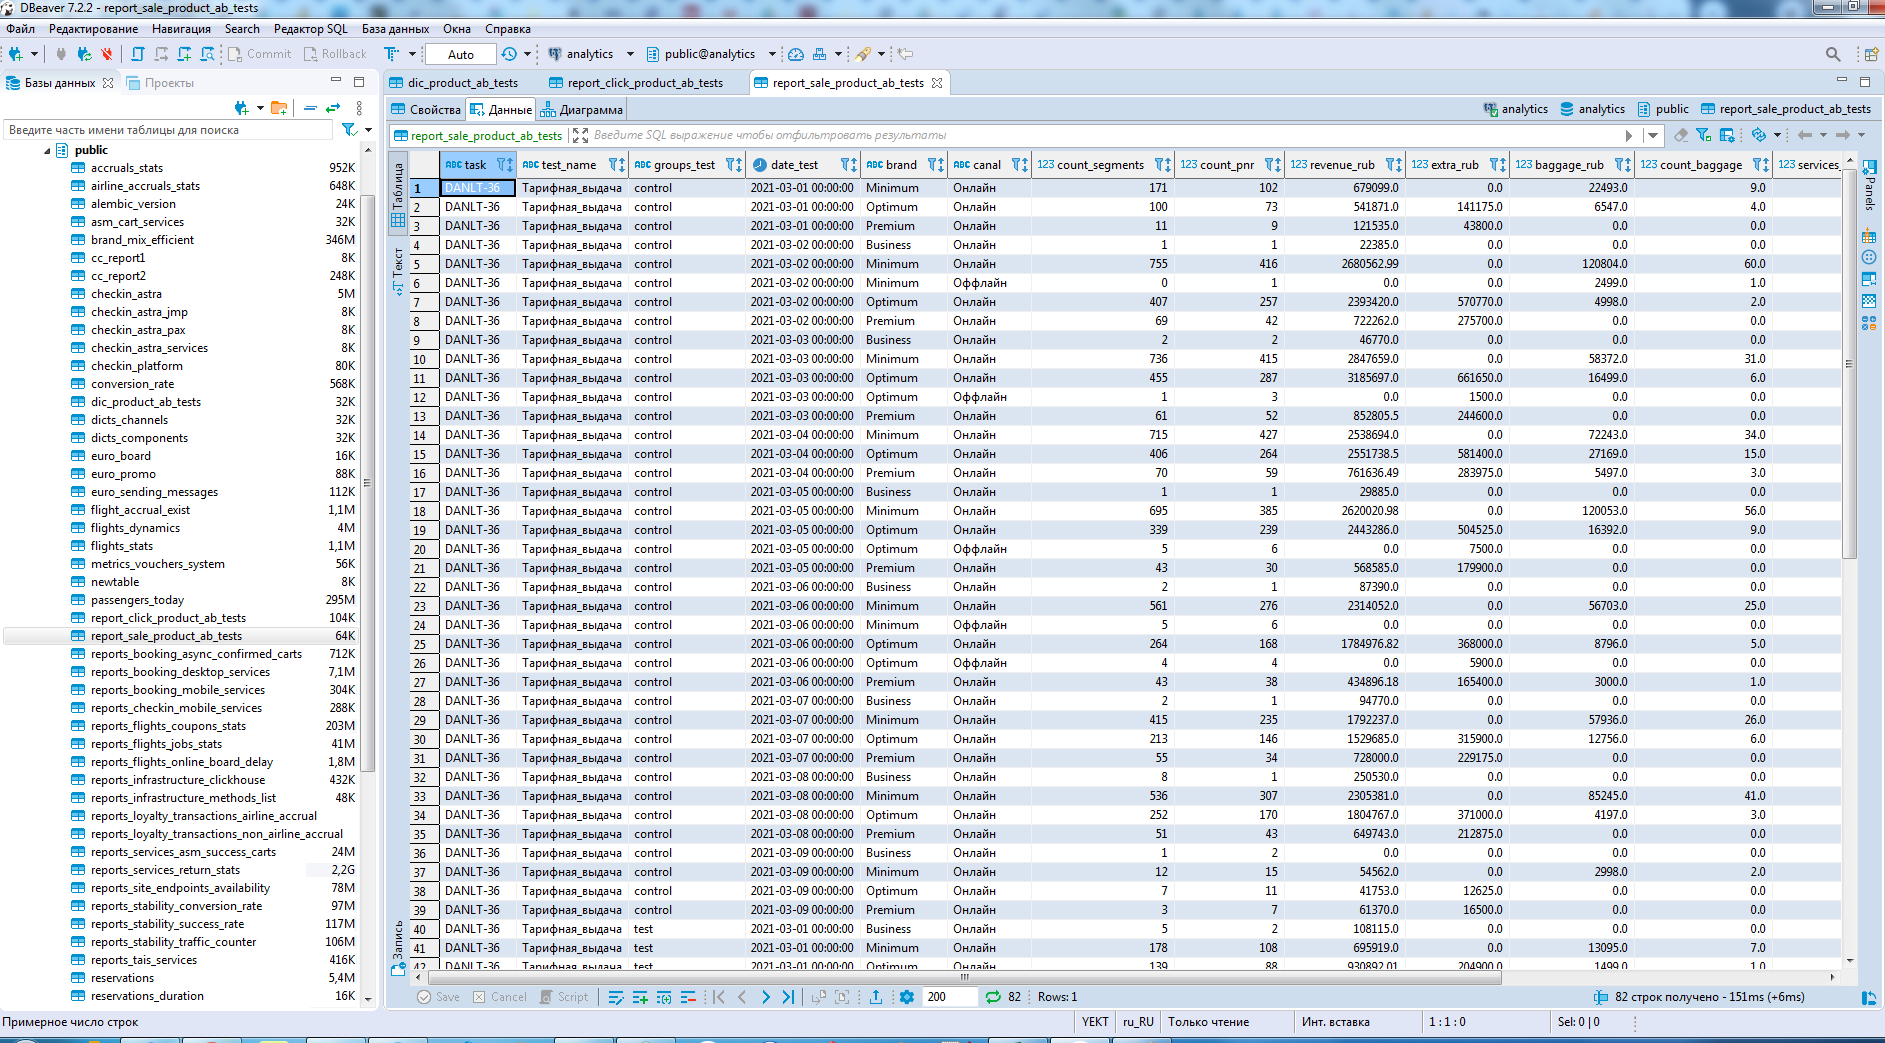

### 11. Результаты

После того как все данные были собраны в БД PostgreSQL в Power BI был настроен отчет "Продуктовые А/B тесты" (см. файл "Часть 1. Продуктовые тесты. Отчет в Power BI").